### Тестовое задание

#### Часть 1. Анализ данных
1. Опишите данные. Используйте памятку по анализу данных из Приложения (не вся информация оттуда релевантна нашим игрушечным данным, но и не нужно ей ограничиваться).
2. Постройте аналитическую витрину, добавьте в нее агрегаты/признаки на ваше усмотрение, которые могут быть полезны как для аналитики, так и для последующего ML.
3. Сформулируйте гипотезы о влиянии тех или иных факторов на продажи.

Примечание: для данной части приветствуется использование pyspark


In [1]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Test task").getOrCreate()

# Проверка успешного подключения
print("Spark Version:", spark.version)

Spark Version: 3.5.4


In [2]:
actions = spark.read.parquet("actions.parquet")

In [3]:
products = spark.read.parquet("products.parquet")

##### Для первого пункта я ориентировалась на приложение, но если что-то было интересно посмотреть, то я добавляла сразу 

#### Посмотрим на функцию describe для таблиц
Но сделаем более лаконичное представление, округлив значения до 2 знаков после запятов, чтоб таблицы были более читаемы

In [4]:
from pyspark.sql import functions as F
desc_act_base = actions.describe()
#пробегаемся по всем колонкам и если значения в этой колонке можно привести к числу с плав.точкой и не нулевое, то округляем
rounded_desc_act = desc_act_base.select(
    *[
        F.when(F.col(c).cast("double").isNotNull(), F.round(F.col(c).cast("double"), 2))
         .otherwise(F.col(c))
         .alias(c)
        for c in desc_act_base.columns
    ]
)

rounded_desc_act.show(truncate=False)

+-------+----------+--------+--------+--------------+--------------+-----------+--------+--------------+---------+
|summary|product_id|store_id|promo_id|promo_type1_id|promo_type2_id|promo_price|discount|promo_type3_id|sales_qty|
+-------+----------+--------+--------+--------------+--------------+-----------+--------+--------------+---------+
|count  |8369.0    |8369.0  |8369.0  |8369.0        |8369.0        |8369.0     |8369.0  |8369.0        |8365.0   |
|mean   |95.28     |1.5     |54.87   |1.06          |3.48          |145.57     |0.22    |1.0           |34692.84 |
|stddev |55.91     |0.5     |31.72   |0.52          |0.85          |144.96     |0.11    |0.03          |91648.82 |
|min    |1.0       |1.0     |1.0     |1.0           |1.0           |14.99      |0.0     |1.0           |0.71     |
|max    |235.0     |2.0     |116.0   |8.0           |6.0           |1499.9     |0.69    |2.0           |2078527.4|
+-------+----------+--------+--------+--------------+--------------+-----------+

In [5]:
desc_prod_base = products.describe()
rounded_desc_prod = desc_prod_base.select(
    *[
        F.when(F.col(c).cast("double").isNotNull(), F.round(F.col(c).cast("double"), 2))
         .otherwise(F.col(c))
         .alias(c)
        for c in desc_prod_base.columns
    ]
)

rounded_desc_prod.show(truncate=False)

+-------+----------+-------------+-------------+-------------+-------------+
|summary|product_id|category_lvl4|category_lvl5|category_lvl3|category_lvl2|
+-------+----------+-------------+-------------+-------------+-------------+
|count  |235.0     |235.0        |235.0        |235.0        |235.0        |
|mean   |118.0     |14.93        |32.99        |2.63         |1.0          |
|stddev |67.98     |12.14        |25.33        |1.88         |0.0          |
|min    |1.0       |1.0          |1.0          |1.0          |1.0          |
|max    |235.0     |46.0         |88.0         |7.0          |1.0          |
+-------+----------+-------------+-------------+-------------+-------------+



В таблицах выше отсутвуют даты, но посмотрим на них попозже

In [6]:
# посмотрим на количество уникальных магазинов и товаров
num_stores = actions.select("store_id").distinct().count()
num_prod_in_actions = actions.select("product_id").distinct().count()
num_prod_in_prod = products.select("product_id").distinct().count()

print("distinct stores in actions:", num_stores)
print("distinct products in actions:", num_prod_in_actions)
print("distinct products in products:", num_prod_in_prod)

distinct stores in actions: 2
distinct products in actions: 235
distinct products in products: 235


In [7]:
# посмотрим находятся ли все товары из actions в справочнике products
num_products_act = actions.select("product_id").distinct()
num_products_prod = products.select("product_id").distinct()
missing_products = num_products_act.join(num_products_prod, on="product_id", how="left_anti")

missing_products_count = missing_products.count()
print("Количество товаров в actions, которые отсутствуют в справочнике products:", missing_products_count)


Количество товаров в actions, которые отсутствуют в справочнике products: 0


В принципе по количесву уникальных товаров в обеих таблицах можно было предположить, что все товары присутствуют, но хорошо, что мы удостоверились, что все товары находятся в справочнике

Дальше посмотрим на то, какой временной период продаж в actions

In [8]:
print("Временной период истории продаж")
agg_date = actions.agg(
    F.min("date_from").alias("min_date_from"),
    F.max("date_from").alias("max_date_from"),
    F.min("date_to").alias("min_date_to"),
    F.max("date_to").alias("max_date_to")
)

agg_date.show(truncate=False)

Временной период истории продаж
+-------------+-------------+-----------+-----------+
|min_date_from|max_date_from|min_date_to|max_date_to|
+-------------+-------------+-----------+-----------+
|2022-06-27   |2024-07-29   |2022-07-03 |2024-08-04 |
+-------------+-------------+-----------+-----------+



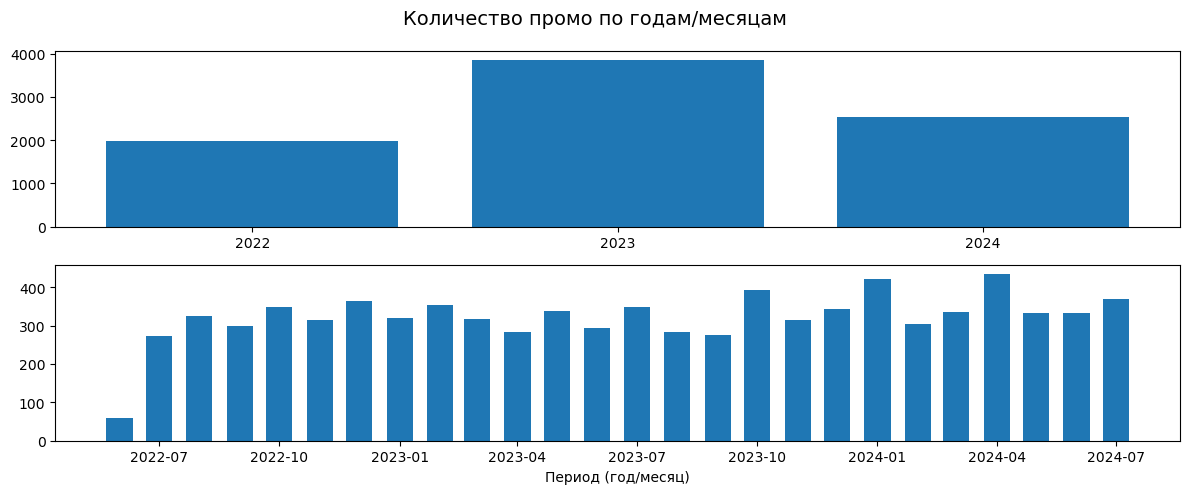

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Добавляем год и месяц
actions = actions.withColumn("year", F.year("date_from")).withColumn("year_month", F.date_format("date_from", "yyyy-MM"))

# Считаем количество промо
promo_cnt_month = actions.groupBy("year_month").agg(F.count("*").alias("count")).orderBy("year_month")
promo_cnt_year = actions.groupBy("year").agg(F.count("*").alias("count")).orderBy("year")


# Подготовка к визуализации
promo_cnt_month = promo_cnt_month.toPandas()
promo_cnt_month["year_month"] = pd.to_datetime(promo_cnt_month['year_month'])
promo_cnt_month = promo_cnt_month.sort_values('year_month')

promo_cnt_year = promo_cnt_year.toPandas()

# Строим график
fig, axes = plt.subplots(2,1, figsize=(12,5), sharey=False)
axes[0].bar(promo_cnt_year["year"].astype(str), promo_cnt_year["count"]) 
axes[1].bar(promo_cnt_month["year_month"], promo_cnt_month["count"], width=20)
axes[1].set_xlabel("Период (год/месяц)")

plt.suptitle("Количество промо по годам/месяцам", fontsize=14)
plt.tight_layout()
plt.show()

#### Проверка на пересечение сроков промо для пары товар-магазин

In [10]:
# Дублируем таблицы
a = actions.select("product_id","store_id","promo_id","date_from","date_to").withColumnRenamed("promo_id","promo_id_a")
b = actions.select("product_id","store_id","promo_id","date_from","date_to").withColumnRenamed("promo_id","promo_id_b")
# Ищем пересечения
overlaps = a.alias("a").join(
    b.alias("b"),
    on=[(F.col("a.product_id")==F.col("b.product_id")),
        (F.col("a.store_id")==F.col("b.store_id"))],
    how="inner").filter(
    (F.col("a.promo_id_a") != F.col("b.promo_id_b")) &
    (F.col("a.date_from") <= F.col("b.date_to")) &
    (F.col("b.date_from") <= F.col("a.date_to"))
)

print("Количество пересечений:", overlaps.count())
overlaps.select("a.product_id","a.store_id","a.promo_id_a","a.date_from","a.date_to",
                "b.promo_id_b","b.date_from","b.date_to").show(truncate=False)

Количество пересечений: 0
+----------+--------+----------+---------+-------+----------+---------+-------+
|product_id|store_id|promo_id_a|date_from|date_to|promo_id_b|date_from|date_to|
+----------+--------+----------+---------+-------+----------+---------+-------+
+----------+--------+----------+---------+-------+----------+---------+-------+



#### Как менялось число различных типов промо в зависимости от временного периода

In [11]:
promo_type_act = actions.withColumn("year", F.year("date_from"))

# число уникальных типов промо по годам
print("Количество различных типов промо по годам")
for col in ["promo_type1_id", "promo_type2_id", "promo_type3_id"]:
    promo_type_act.groupBy("year").agg(F.countDistinct(col).alias(f"distinct_{col}")).orderBy("year").show()

# число уникальных типов промо по месяцам
print("Количество различных типов промо по месяцам")
# Добавляем год-месяц
promo_type_act = actions.withColumn("year_month", F.date_format("date_from", "yyyy-MM"))

promo_type_act2 = promo_type_act.groupBy("year_month").agg(
    F.countDistinct("promo_type1_id").alias("distinct_promo_type1"),
    F.countDistinct("promo_type2_id").alias("distinct_promo_type2"),
    F.countDistinct("promo_type3_id").alias("distinct_promo_type3")
).orderBy("year_month")
promo_type_act2.show()

Количество различных типов промо по годам
+----+-----------------------+
|year|distinct_promo_type1_id|
+----+-----------------------+
|2022|                      3|
|2023|                      4|
|2024|                      2|
+----+-----------------------+

+----+-----------------------+
|year|distinct_promo_type2_id|
+----+-----------------------+
|2022|                      6|
|2023|                      6|
|2024|                      6|
+----+-----------------------+

+----+-----------------------+
|year|distinct_promo_type3_id|
+----+-----------------------+
|2022|                      2|
|2023|                      1|
|2024|                      2|
+----+-----------------------+

Количество различных типов промо по месяцам
+----------+--------------------+--------------------+--------------------+
|year_month|distinct_promo_type1|distinct_promo_type2|distinct_promo_type3|
+----------+--------------------+--------------------+--------------------+
|   2022-06|                   1

#### Преобразуем в график

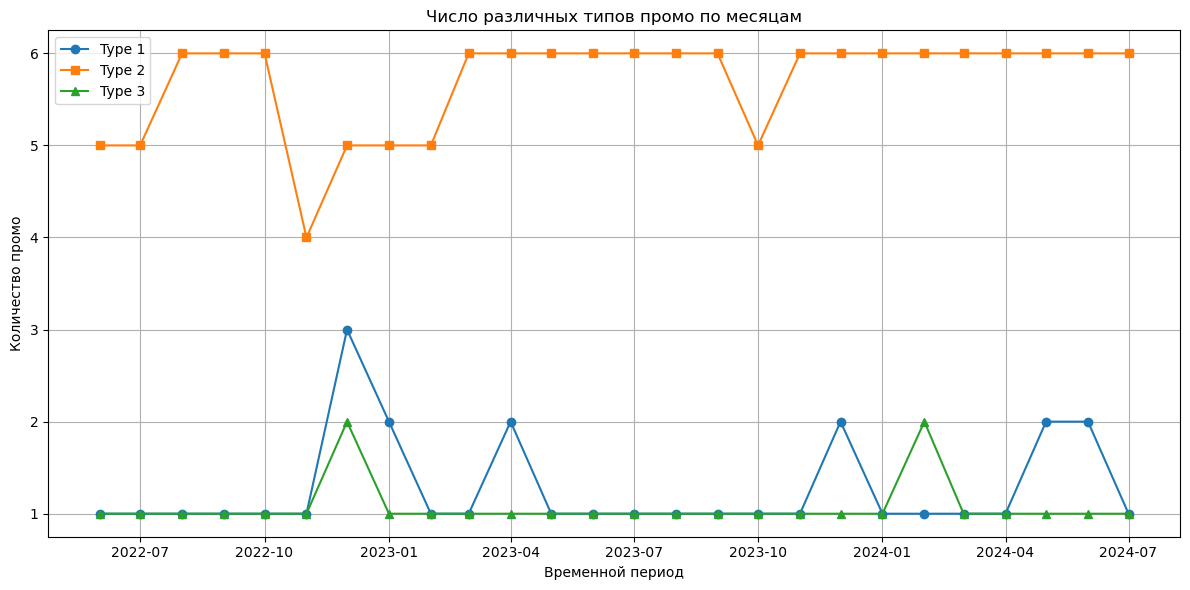

In [12]:
df = promo_type_act2.toPandas()
# Отсортируем даты
df['year_month'] = pd.to_datetime(df['year_month'])
df = df.sort_values('year_month')

# Строим график
plt.figure(figsize=(12,6))
plt.plot(df['year_month'], df['distinct_promo_type1'], label="Type 1", marker="o")
plt.plot(df['year_month'], df['distinct_promo_type2'], label="Type 2", marker="s")
plt.plot(df['year_month'], df['distinct_promo_type3'], label="Type 3", marker="^")

plt.title("Число различных типов промо по месяцам")
plt.xlabel("Временной период")
plt.ylabel("Количество промо")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

####  Распределение длительности промо в зависимости от промо, а также в какие дни недели они заканчиваются и начинаются

+-------------------+-----+
|promo_duration_days|count|
+-------------------+-----+
|                  1|    6|
|                  2|  104|
|                  3|  119|
|                  4|  151|
|                  5|    4|
|                  7| 7897|
|                 14|   88|
+-------------------+-----+



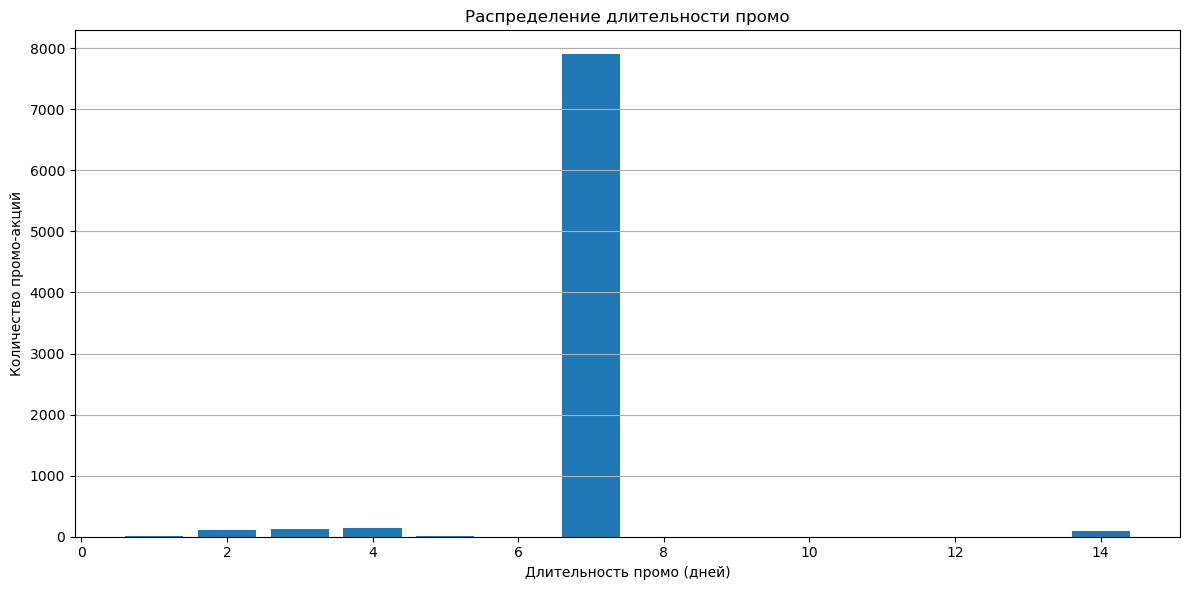

In [13]:
#добавляем колонку с длительностью промо
actions = actions.withColumn("promo_duration_days", F.datediff("date_to", "date_from") + F.lit(1))

duration_dist = actions.groupBy("promo_duration_days").agg(F.count("*").alias("count")).orderBy("promo_duration_days")
duration_dist.show()
duration_dist = duration_dist.toPandas()

# Строим гистограмму (bar chart)
plt.figure(figsize=(12,6))
plt.bar(duration_dist["promo_duration_days"], duration_dist["count"])
plt.xlabel("Длительность промо (дней)")
plt.ylabel("Количество промо-акций")
plt.title("Распределение длительности промо")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [14]:
# начало/конец по дням недели
actions = actions.withColumn("start_day", F.date_format("date_from", "E")) \
                 .withColumn("end_day", F.date_format("date_to", "E"))

actions.groupBy("start_day").agg(F.count("*").alias("count_start")).orderBy("count_start", ascending=False).show()
actions.groupBy("end_day").agg(F.count("*").alias("count_end")).orderBy("count_end", ascending=False).show()

+---------+-----------+
|start_day|count_start|
+---------+-----------+
|      Mon|       8177|
|      Thu|         96|
|      Fri|         47|
|      Wed|         24|
|      Tue|         14|
|      Sun|          7|
|      Sat|          4|
+---------+-----------+

+-------+---------+
|end_day|count_end|
+-------+---------+
|    Sun|     8094|
|    Thu|       92|
|    Wed|       69|
|    Tue|       60|
|    Sat|       26|
|    Fri|       26|
|    Mon|        2|
+-------+---------+



,start_day,count
0,Sun,7
1,Mon,8177
2,Thu,96
3,Sat,4
4,Wed,24
5,Fri,47
6,Tue,14


,end_day,count
0,Sun,8094
1,Mon,2
2,Thu,92
3,Sat,26
4,Wed,69
5,Tue,60
6,Fri,26


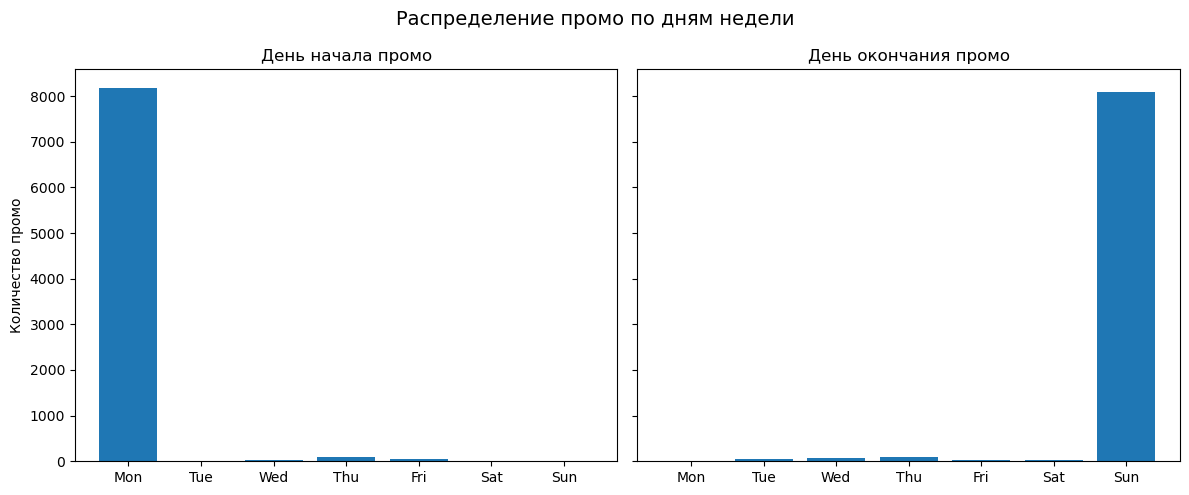

In [15]:
start_counts = actions.groupBy("start_day").agg(F.count("*").alias("count")).toPandas()
end_counts = actions.groupBy("end_day").agg(F.count("*").alias("count")).toPandas()
display(start_counts)
display(end_counts)

# Чтобы дни недели были в правильном порядке:
day_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
start_counts["start_day"] = pd.Categorical(start_counts["start_day"], categories=day_order, ordered=True)
end_counts["end_day"] = pd.Categorical(end_counts["end_day"], categories=day_order, ordered=True)

start_counts = start_counts.sort_values("start_day")
end_counts = end_counts.sort_values("end_day")

fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

axes[0].bar(start_counts["start_day"], start_counts["count"])
axes[0].set_title("День начала промо")
axes[0].set_ylabel("Количество промо")

axes[1].bar(end_counts["end_day"], end_counts["count"])
axes[1].set_title("День окончания промо")

plt.suptitle("Распределение промо по дням недели", fontsize=14)
plt.tight_layout()
plt.show()

Выяснили, что в среднем длительность промо 7 дней, день начала - Понедельник, день окончания - Воскресенье

#### В предоставленных данных отсутствует регулярные цены на товары, поэтому проверить, что цены промо меньше или равны регулярным не получится, также как и проверить, что нет случаев, когда промо-ценник выставлялся на день раньше старта промо, так как ещё и нет фактической цены

Вообще регулярную цену можно вычислить с помощью discount и promo_price, но это лишено смысла, т.к. цена таким образом не получится меньше цены промо, т.к. discount от 0 до 0.69

Поэтому наверно здесь предполагаются какие-то другие данные

#### В данном случае что можно ещё посмотреть 
* Посмотреть на динамику максимальной/минимальной/средней ценой промо для конкретного товара и для всех товаров
* Посмотреть на цены между последовательными промо

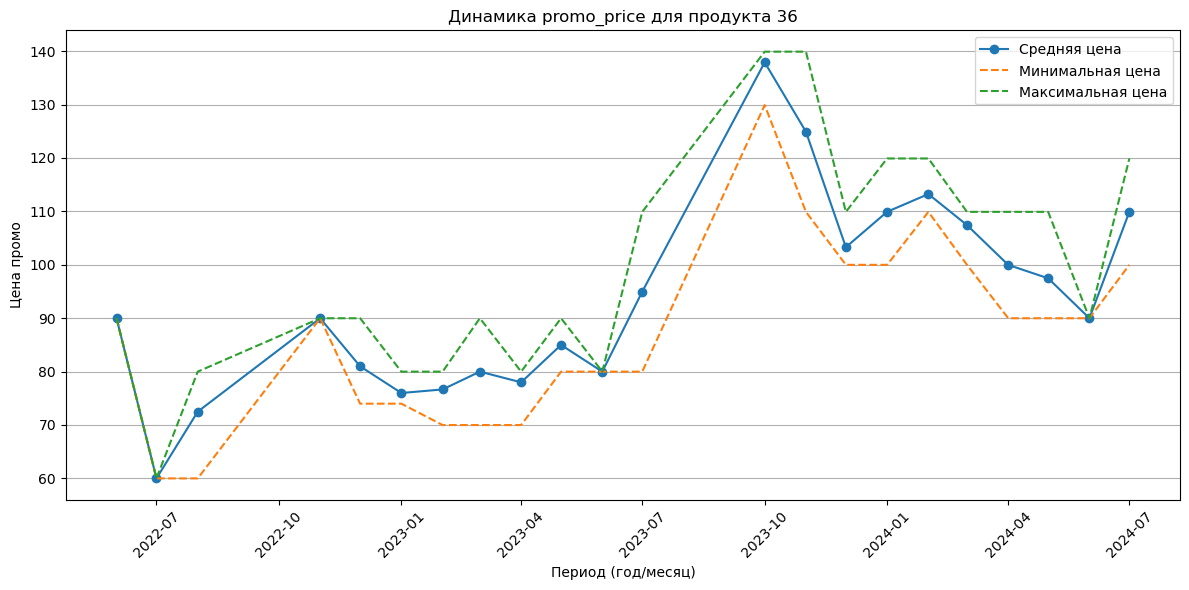

In [16]:
promo_price_stats = actions.groupBy("product_id", "year_month").agg(
    F.min("promo_price").alias("min_promo_price"),
    F.avg("promo_price").alias("avg_promo_price"),
    F.max("promo_price").alias("max_promo_price")
)
stats = promo_price_stats.toPandas()
stats["year_month"] = pd.to_datetime(stats['year_month'])
stats = stats.sort_values('year_month')

# Выбираем один продукт
sample = stats[(stats["product_id"] == stats["product_id"].iloc[0])]
             

plt.figure(figsize=(12,6))

plt.plot(sample["year_month"], sample["avg_promo_price"], marker="o", label="Средняя цена")
plt.plot(sample["year_month"], sample["min_promo_price"], linestyle="--", label="Минимальная цена")
plt.plot(sample["year_month"], sample["max_promo_price"], linestyle="--", label="Максимальная цена")

plt.title(f"Динамика promo_price для продукта {sample['product_id'].iloc[0]}")
plt.xlabel("Период (год/месяц)")
plt.ylabel("Цена промо")
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

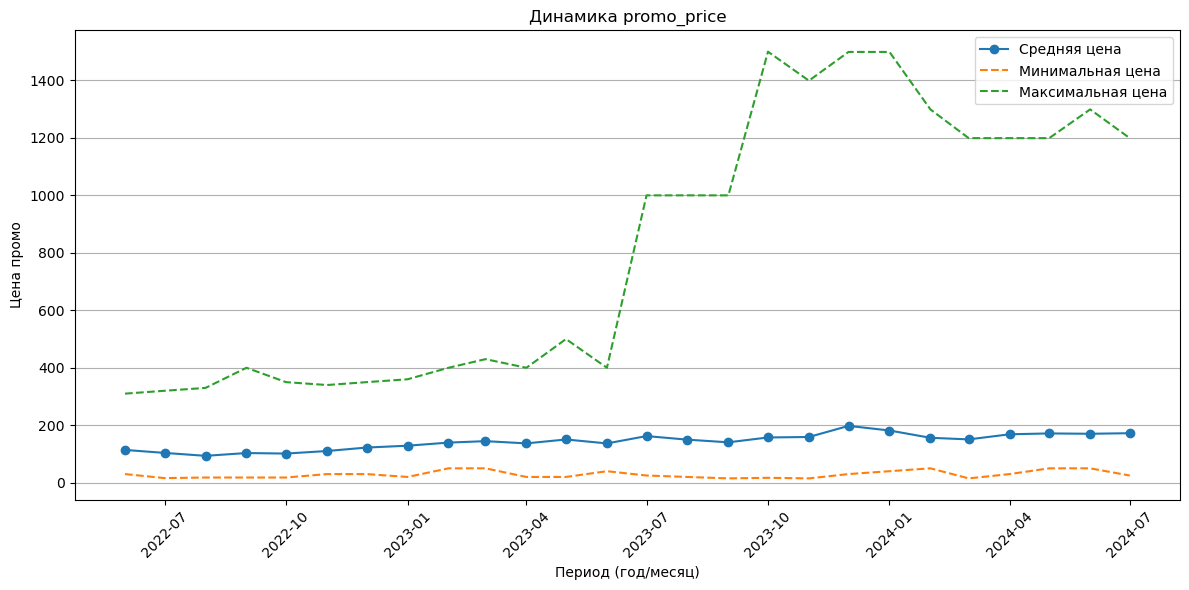

In [17]:
promo_price_stats = actions.groupBy("year_month").agg(
    F.min("promo_price").alias("min_promo_price"),
    F.avg("promo_price").alias("avg_promo_price"),
    F.max("promo_price").alias("max_promo_price")
)
stats = promo_price_stats.toPandas()
stats["year_month"] = pd.to_datetime(stats['year_month'])
stats = stats.sort_values('year_month')

plt.figure(figsize=(12,6))

plt.plot(stats["year_month"], stats["avg_promo_price"], marker="o", label="Средняя цена")
plt.plot(stats["year_month"], stats["min_promo_price"], linestyle="--", label="Минимальная цена")
plt.plot(stats["year_month"], stats["max_promo_price"], linestyle="--", label="Максимальная цена")

plt.title(f"Динамика promo_price")
plt.xlabel("Период (год/месяц)")
plt.ylabel("Цена промо")
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

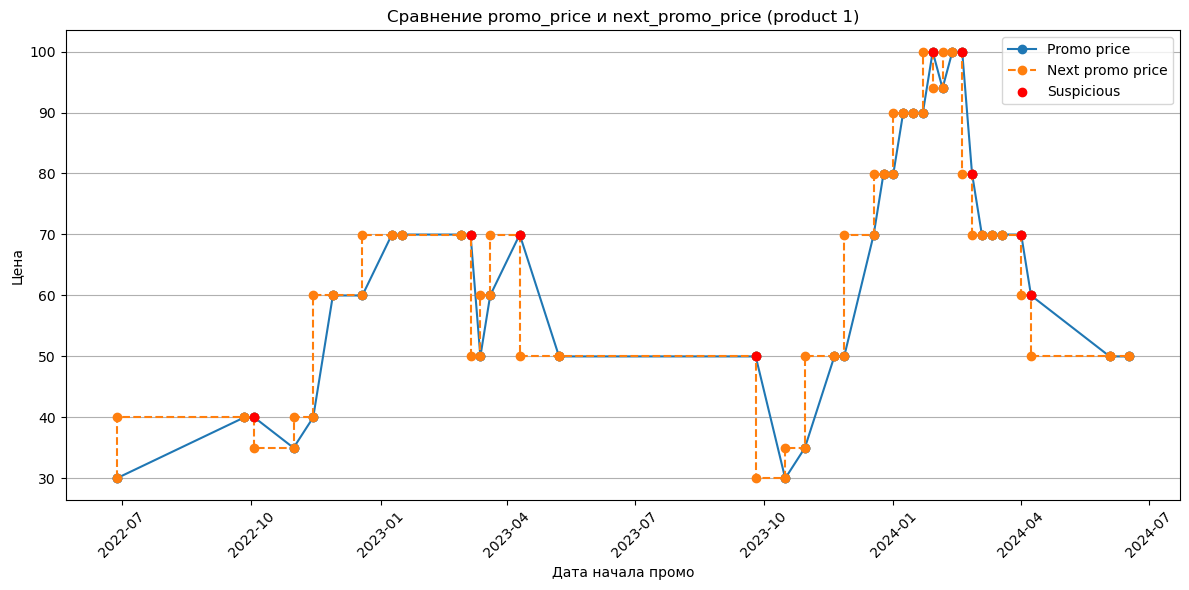

In [18]:
from pyspark.sql import Window

w = Window.partitionBy("product_id").orderBy("date_from")

actions_with_next = actions.withColumn(
    "next_promo_price", F.lead("promo_price").over(w))


tmp = actions_with_next.toPandas()
tmp["date_from"] = pd.to_datetime(tmp["date_from"])

# Чтоб визуально было понятно делаем визуализацию по одному продукту
sample = tmp[(tmp["product_id"] == tmp["product_id"].iloc[0])]

plt.figure(figsize=(12,6))

# Линия с promo_price
plt.plot(sample["date_from"], sample["promo_price"], marker="o", label="Promo price")

# Линия с next_promo_price
plt.plot(sample["date_from"], sample["next_promo_price"], marker="o", linestyle="--", label="Next promo price")

# promo_price > next_promo_price
suspicious = sample[sample["promo_price"] > sample["next_promo_price"]]
plt.scatter(suspicious["date_from"], suspicious["promo_price"], color="red", zorder=3, label="Suspicious")

plt.title(f"Сравнение promo_price и next_promo_price (product {sample['product_id'].iloc[0]})")
plt.xlabel("Дата начала промо")
plt.ylabel("Цена")
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

Технически эти графики мало что дают, т.к. сравнение с регулярной ценой было бы более информативно и полезно, но тем не менее что можно вынести из графиков
* Одинаковая тенденция роста цены промо при рассмотрении конкретного товара и всех, в период июля - октября 2023 года был заметный рост цены промо, причем этот же период у нас есть в 2022 в данных и там такого эффекта не наблюдается, значит это какой-то уникальный эффект и сезонности здесь не присутствует, что-то происходило в тот момент, может тренд, высокий спрос и т.п.
* Красными точками на последнем графике отмечены случаи, когда цена следующего промо ниже предыдущего, что может, например, говорить о том что цель предыдущего промо не выполнена и не получилось привлечь новых покупателей или стимулировать продажи и поэтому нужно ещё снижать цену промо.

#### При наличии товарной иерархии посмотреть число групп на различных уровнях, убедиться, что нет групп, совпадающих по названию с точностью до нескольких символов (разный регистр, множественное или единственное число)

Адекватно проверить это не получиться т.к. группы представленны в данных цифрами и тут не проверить отличается ли у кого-то регистр или мн./ед. число
Ниже написала код, который на нормальных названиях должен работать, а так из важного только количество групп на каждом уровне


In [19]:
category = ["category_lvl2","category_lvl3","category_lvl4","category_lvl5"]
# количество групп на различных уровнях
for group in category:
    count = products.select(group).distinct().count()
    print(f"{group}: {count} групп")

# Нормализируем названия
products2 = products
for group in category:
    clean_col = F.lower(F.trim(F.regexp_replace(F.col(group), r"[^a-zA-Z0-9а-яА-Я\s]", "")))
    products2 = products2.withColumn(f"{group}_norm", clean_col)

# Ищем дубликаты
for group in category:
    norm_col = f"{group}_norm"
    print(f"\nПроверка категории: {group}")
    products2.groupBy(norm_col).agg(
            F.collect_set(group).alias("variants"), 
            F.countDistinct("product_id").alias("cnt")
        ).filter(F.size("variants") > 1).show(truncate=False)


category_lvl2: 1 групп
category_lvl3: 7 групп
category_lvl4: 46 групп
category_lvl5: 88 групп

Проверка категории: category_lvl2
+------------------+--------+---+
|category_lvl2_norm|variants|cnt|
+------------------+--------+---+
+------------------+--------+---+


Проверка категории: category_lvl3
+------------------+--------+---+
|category_lvl3_norm|variants|cnt|
+------------------+--------+---+
+------------------+--------+---+


Проверка категории: category_lvl4
+------------------+--------+---+
|category_lvl4_norm|variants|cnt|
+------------------+--------+---+
+------------------+--------+---+


Проверка категории: category_lvl5
+------------------+--------+---+
|category_lvl5_norm|variants|cnt|
+------------------+--------+---+
+------------------+--------+---+



#### 2. Постройте аналитическую витрину, добавьте в нее агрегаты/признаки на ваше усмотрение, которые могут быть полезны как для аналитики, так и для последующего ML.

#### Какие признаки я добавила в витрину:
* product_id
* store_id
* year - год
* month - месяц

Агрегированные признаки по product_id, store_id, year, month:

* promo_count - количество промо
* avg_promo_duration - ср. длительность промо
* total_sales_qty - сумма продаж в штуках
* avg_promo_price - ср. цена промо
  
Средняя/максимальная/минимальная сумма продаж товара в контретном магазине за конкретный месяц:
* mean_sales_qty_store
* max_sales_qty_store
* min_sales_qty_store


Окно для лагов по ценам промо

* prev_avg_promo_price
* price_jump_flag - бинарная переменная, если цена выросла

In [20]:
actions1 = spark.read.parquet("actions.parquet")
products1 = spark.read.parquet("products.parquet")

In [21]:
joined = actions1.join(products1, on="product_id", how="left")

In [22]:
joined = joined \
    .withColumn("year", F.year("date_from")) \
    .withColumn("month", F.month("date_from")) \
    .withColumn("promo_duration", F.datediff("date_to", "date_from")) 

In [23]:
window_prod_store = Window.partitionBy("product_id", "store_id")
joined = joined.withColumn("mean_sales_qty", F.mean("sales_qty").over(window_prod_store)) \
               .withColumn("max_sales_qty", F.max("sales_qty").over(window_prod_store))\
                .withColumn("min_sales_qty", F.min("sales_qty").over(window_prod_store))

In [24]:
agg_df = joined.groupBy("product_id", "store_id", "year", "month").agg(
    F.countDistinct("promo_id").alias("promo_count"),
    F.mean("promo_duration").alias("avg_promo_duration"),
    F.sum("sales_qty").alias("total_sales_qty"),
    F.round(F.mean("promo_price"),2).alias("avg_promo_price"),
    F.round(F.first("mean_sales_qty"),2).alias("mean_sales_qty"),
    F.round(F.first("max_sales_qty"),2).alias("max_sales_qty"),
    F.round(F.first("min_sales_qty"),2).alias("min_sales_qty")
)

In [25]:
window_log_price = Window.partitionBy("product_id", "store_id").orderBy("year", "month")
agg_df = agg_df.withColumn("prev_avg_promo_price", F.lag("avg_promo_price").over(window_log_price))
agg_df = agg_df.withColumn("price_jump_flag", F.when(F.col("prev_avg_promo_price").isNotNull() 
                                                     & (F.col("avg_promo_price") > F.col("prev_avg_promo_price")), 1).otherwise(0))


In [26]:
agg_df.show()

+----------+--------+----+-----+-----------+------------------+---------------+---------------+--------------+-------------+-------------+--------------------+---------------+
|product_id|store_id|year|month|promo_count|avg_promo_duration|total_sales_qty|avg_promo_price|mean_sales_qty|max_sales_qty|min_sales_qty|prev_avg_promo_price|price_jump_flag|
+----------+--------+----+-----+-----------+------------------+---------------+---------------+--------------+-------------+-------------+--------------------+---------------+
|         1|       1|2022|    6|          1|               6.0|        14580.0|          29.98|      40175.92|      63540.0|       6460.0|                NULL|              0|
|         1|       1|2022|    9|          1|               6.0|        17732.0|          39.99|      40175.92|      63540.0|       6460.0|               29.98|              1|
|         1|       1|2022|   10|          2|               6.0|        56566.0|          37.49|      40175.92|      6354

In [ ]:
#agg_df.write.mode("overwrite").parquet("analytical_show_window.parquet")

#### 3. Сформулируйте гипотезы о влиянии тех или иных факторов на продажи.

#### Часть 2. Прогноз
1. Постройте прогноз продаж (sales_qty) на февраль 2024г* с горизонтом 2 недели** на уровне товар - магазин -  ID промо - промо-период.
* Таким образом, должны быть спрогнозированы все промо-периоды, которые начинаются на февральских неделях
* Под горизонтом понимается разница в неделях между точкой, из которой производится прогнозирование и неделей прогнозируемых продаж (считаем от понедельника недели, в которой началось промо - например, если промо началось во вторник 2024-02-21, то точкой прогнозирования будет 2024-02-06, т.е. 2024-02-20 (пн) минус 2*7 (две недели).
2. Сравните прогноз с фактом с помощью метрик WAPE и BIAS за апрель 2024 на уровне товарной категории 3 (category_lvl3).

In [27]:
spark = SparkSession.builder.appName("Test task2").getOrCreate()
print("Spark Version:", spark.version)

Spark Version: 3.5.4


In [28]:
actions2 = spark.read.parquet("actions.parquet")
products2 = spark.read.parquet("products.parquet")

joined = actions2.join(products2, on="product_id", how="left")

joined = (
    joined.withColumn("promo_duration_days", F.datediff("date_to", "date_from"))
      .withColumn("year", F.year("date_from"))
      .withColumn("month", F.month("date_from"))
      .withColumn("week", F.weekofyear("date_from"))
)
w = Window.partitionBy("product_id", "store_id").orderBy("date_from")
joined = joined.withColumn("lag1_sales", F.lag("sales_qty", 1).over(w))
joined = joined.withColumn("lag2_sales", F.lag("sales_qty", 2).over(w))
joined = joined.withColumn("lag3_sales", F.lag("sales_qty", 3).over(w))
joined = joined.withColumn("mean_last3_sales", (F.col("lag1_sales")+F.col("lag2_sales")+F.col("lag3_sales"))/3)

In [ ]:
df1 = joined.toPandas()
df1["date_from"] = pd.to_datetime(df1["date_from"])

In [36]:
# Делим данные на трейн и тест
train = df1[df1["date_from"] < pd.Timestamp("2024-02-01")]
test_feb = df1[(df1["date_from"] >= pd.Timestamp("2024-02-01")) & (df1["date_from"] < pd.Timestamp("2024-03-01"))]
test_apr = df1[(df1["date_from"] >= pd.Timestamp("2024-04-01")) & (df1["date_from"] < pd.Timestamp("2024-05-01"))]

train = train.dropna(subset = ["sales_qty"])

features = ["promo_duration_days", "mean_last3_sales", "promo_type1_id", "promo_type2_id", "promo_type3_id"]
X_train, y_train = train[features], train["sales_qty"]
X_test_feb, y_test_feb = test_feb[features], test_feb["sales_qty"]
X_test_apr, y_test_apr = test_apr[features], test_apr["sales_qty"]

далее выясниться что в данных есть NaN, можно либо заполнить нулями эти значения, либо удалить. Я решила удалить так как всего одно наблюдение имеет NaN.

#### Обучаем модель
Какие модели можно попробавь:
* RandomForest
* XGBoost
* SVM
* gradient boosting

In [38]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train.fillna(0), y_train)

# Прогноз на февраль и апрель
test_feb["y_hat"] = model.predict(X_test_feb.fillna(0))
test_apr["y_hat"] = model.predict(X_test_apr.fillna(0))

C:\Users\Екатерина\AppData\Local\Temp\ipykernel_26788\2602363362.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_feb["y_hat"] = model.predict(X_test_feb.fillna(0))
C:\Users\Екатерина\AppData\Local\Temp\ipykernel_26788\2602363362.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_apr["y_hat"] = model.predict(X_test_apr.fillna(0))


In [40]:
import numpy as np
# 4️⃣ Метрики на апрель (WAPE и BIAS по category_lvl3)
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)

def bias(y_true, y_pred):
    return np.sum(y_pred - y_true) / np.sum(y_true)

metrics = test_apr.groupby("category_lvl3").apply(
    lambda g: pd.Series({
        "WAPE": wape(g["sales_qty"], g["y_hat"]),
        "BIAS": bias(g["sales_qty"], g["y_hat"])
    })
).reset_index()

print(metrics)

   category_lvl3      WAPE      BIAS
0              1  0.285619 -0.012711
1              2  0.283391  0.061095
2              3  0.329933  0.198997
3              5  0.397959  0.080758
4              6  0.153749  0.063501
5              7  0.512060  0.091011


C:\Users\Екатерина\AppData\Local\Temp\ipykernel_26788\1731742748.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics = test_apr.groupby("category_lvl3").apply(


WAPE → чем меньше, тем лучше (0 — идеальный прогноз).

BIAS:

≈ 0 → модель не систематически завышает или занижает прогноз.

0 → модель переоценивает продажи.

< 0 → модель недооценивает продажи.

#### Часть 3. Интерпретация и презентация
1. Объясните, какие факторы повлияли на качество прогноза.
2. Какие данные и/или признаки вы бы добавили для улучшения прогноза?
3. Ваши общие выводы и рекомендации
